<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Plant_disease_classification/blob/master/ResNet_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50
from keras import optimizers
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dst_path = '/content/gdrive/My Drive/dataset_split_aug'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/dataset_split_aug')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(dst_path, 'train')
validation_dir = os.path.join(dst_path, 'validation')
test_dir = os.path.join(dst_path, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=64,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(64,64),
                                                        batch_size=64,
                                                        class_mode='categorical')

Found 30748 images belonging to 33 classes.
Found 7989 images belonging to 33 classes.


In [ ]:
SIZE=64
N_ch=3

In [ ]:
input_tensor = Input(shape=(SIZE, SIZE, N_ch))
conv_base = ResNet50(include_top=False, weights='imagenet',input_tensor=input_tensor,pooling='max')
conv_base.trainable = True

94658560/94653016 [==============================] - 2s 0us/step


In [ ]:
for layer in conv_base.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fbd0029ed68> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fbd0029ee48> True
<keras.layers.convolutional.Conv2D object at 0x7fbcfdb06b38> True
<keras.layers.normalization.BatchNormalization object at 0x7fbd00253128> True
<keras.layers.core.Activation object at 0x7fbd00253240> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fbd62cb7a58> True
<keras.layers.pooling.MaxPooling2D object at 0x7fbcebe37f28> True
<keras.layers.convolutional.Conv2D object at 0x7fbcebbd6f60> True
<keras.layers.normalization.BatchNormalization object at 0x7fbcebc004e0> True
<keras.layers.core.Activation object at 0x7fbce006ecc0> True
<keras.layers.convolutional.Conv2D object at 0x7fbc9017b3c8> True
<keras.layers.normalization.BatchNormalization object at 0x7fbc9018ec50> True
<keras.layers.core.Activation object at 0x7fbc9018e668> True
<keras.layers.convolutional.Conv2D object at 0x7fbc901abc50> True
<keras.layers.convolutional.Conv2D obj

In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

Reduce On Pleateau lr값 조절.  런타임 새로돌림 (0620)

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
MODEL_SAVE_FOLDER_PATH='/content/gdrive/My Drive/'
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}_halfFreeze2_lrEdit.hdf5'
checkpoint= ModelCheckpoint(filepath=model_path,monitor='val_acc',verbose=1, save_best_only=True)
earlystop=EarlyStopping(patience=15)
my_callbacks = [checkpoint, annealer]

In [ ]:
# Fits the model on batches with real-time data augmentation
resnet = model.fit_generator(train_generator, steps_per_epoch=500,
                            epochs=50,
                            validation_data=validation_generator,
                            callbacks=my_callbacks)

Epoch 1/50
500/500 [==============================] - 7896s 16s/step - loss: 1.0850 - accuracy: 0.7392 - val_loss: 10.5468 - val_accuracy: 0.0214

Epoch 00001: val_accuracy improved from -inf to 0.02140, saving model to /content/gdrive/My Drive/01-10.5468_halfFreeze.hdf5
Epoch 2/50
500/500 [==============================] - 126s 251ms/step - loss: 1.0096 - accuracy: 0.7693 - val_loss: 143.4207 - val_accuracy: 0.0907

Epoch 00002: val_accuracy improved from 0.02140 to 0.09075, saving model to /content/gdrive/My Drive/02-143.4207_halfFreeze.hdf5
Epoch 3/50
500/500 [==============================] - 122s 245ms/step - loss: 0.8019 - accuracy: 0.8033 - val_loss: 1.1519 - val_accuracy: 0.7364

Epoch 00003: val_accuracy improved from 0.09075 to 0.73639, saving model to /content/gdrive/My Drive/03-1.1519_halfFreeze.hdf5
Epoch 4/50
500/500 [==============================] - 123s 246ms/step - loss: 0.4988 - accuracy: 0.8680 - val_loss: 0.5826 - val_accuracy: 0.8408

Epoch 00004: val_accuracy imp

In [ ]:
from keras.models import load_model
model.save('plant_resnet_halfTrain_reducePleateaulr.h5')

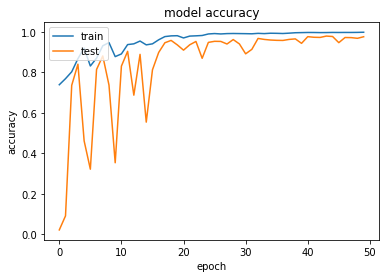

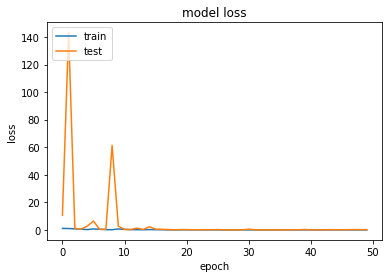

In [ ]:
# accuracy plot 
plt.plot(resnet.history['accuracy'])
plt.plot(resnet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(resnet.history['loss'])
plt.plot(resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

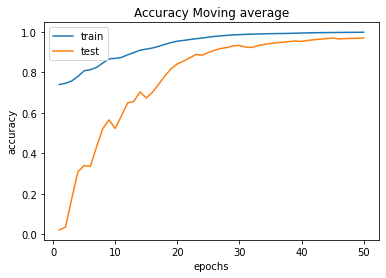

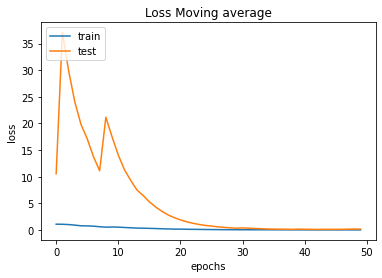

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(resnet.history['accuracy'])
smooth_mae_history_val = smooth_curve(resnet.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(smooth_curve(resnet.history['loss']))
plt.plot(smooth_curve(resnet.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

모델2 -얼리스탑 안걸었는데 reduce on pleateau lr 잘못줘서 무한반복중

In [ ]:
# Fits the model on batches with real-time data augmentation
resnet = model.fit_generator(train_generator, steps_per_epoch=500,
                            epochs=50,
                            validation_data=validation_generator,
                            callbacks=my_callbacks)

Epoch 1/50
500/500 [==============================] - 166s 332ms/step - loss: 0.0670 - accuracy: 0.9775 - val_loss: 1.7840 - val_accuracy: 0.6460
Epoch 2/50
  1/500 [..............................] - ETA: 1:07 - loss: 0.0492 - accuracy: 0.9844

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


500/500 [==============================] - 161s 323ms/step - loss: 0.0594 - accuracy: 0.9807 - val_loss: 3.3717 - val_accuracy: 0.5754
Epoch 3/50
500/500 [==============================] - 163s 327ms/step - loss: 0.0580 - accuracy: 0.9809 - val_loss: 0.5610 - val_accuracy: 0.8723
Epoch 4/50
500/500 [==============================] - 160s 321ms/step - loss: 0.0547 - accuracy: 0.9810 - val_loss: 0.4382 - val_accuracy: 0.9249
Epoch 5/50
500/500 [==============================] - 162s 324ms/step - loss: 0.0712 - accuracy: 0.9777 - val_loss: 0.3500 - val_accuracy: 0.8775
Epoch 6/50
500/500 [==============================] - 160s 320ms/step - loss: 0.0527 - accuracy: 0.9819 - val_loss: 0.1872 - val_accuracy: 0.8902
Epoch 7/50
500/500 [==============================] - 161s 322ms/step - loss: 0.0505 - accuracy: 0.9824 - val_loss: 0.8408 - val_accuracy: 0.8468
Epoch 8/50
500/500 [==============================] - 163s 326ms/step - loss: 0.0471 - accuracy: 0.9838 - val_loss: 0.6209 - val_accura

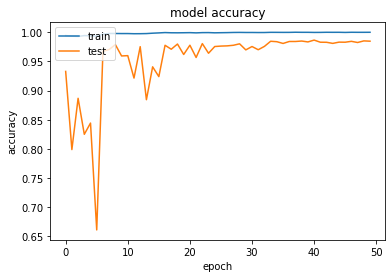

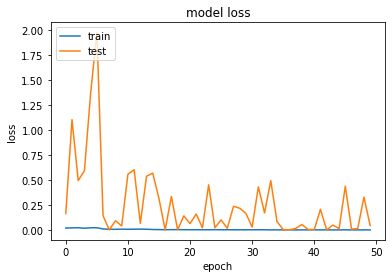

In [ ]:
# accuracy plot 
plt.plot(resnet.history['accuracy'])
plt.plot(resnet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(resnet.history['loss'])
plt.plot(resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

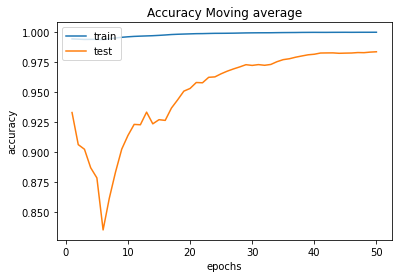

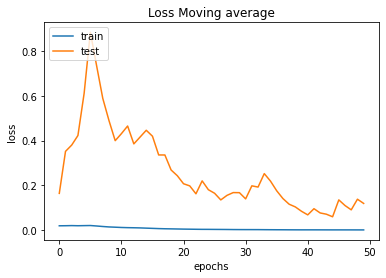

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(resnet.history['accuracy'])
smooth_mae_history_val = smooth_curve(resnet.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(smooth_curve(resnet.history['loss']))
plt.plot(smooth_curve(resnet.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()